In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import imageio
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from collections import deque

In [2]:
# Testing
env = gym.make('LunarLander-v3', render_mode="human")
state, _ = env.reset(seed=30)

while True:
    action = env.action_space.sample() 
    observation, reward, terminated, truncated, _ = env.step(action)
    if isinstance(terminated, bool) and isinstance(truncated, bool):
        if terminated or truncated:
            break
    else:
        if terminated.item() or truncated.item():
            break
        
env.close()

In [3]:
class SafeAgent:
    def act(self, state):
        return 2 if state[1] < 1 else 0


def play_episode(env, agent, seed=42, save_path='lunar_lander.gif'):
    state, _ = env.reset(seed=seed)
    frames = []
    score = 0
    
    while True:
        frames.append(env.render())
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action) 
        score += reward

        if terminated or truncated:
            break

    imageio.mimsave(save_path, frames, duration=0.1,fps=60)
    env.close()
    return score

if __name__ == "__main__":
    env = gym.make('LunarLander-v3', render_mode='rgb_array')
    agent = SafeAgent()
    score = play_episode
    print(f"Episode Score: {score}")

Episode Score: <function play_episode at 0x000002BE9E8FF370>


In [4]:
class DQN(torch.nn.Module):
    def __init__(self, state_size=8, action_size=4, hidden_size=64):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, state):
        return self.net(state)

In [5]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (torch.FloatTensor(states), 
                torch.LongTensor(actions), 
                torch.FloatTensor(rewards), 
                torch.FloatTensor(next_states), 
                torch.FloatTensor(dones))

    def __len__(self):
        return len(self.buffer)

In [6]:
class DQNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-4, gamma=0.99, buffer=10000, batch=64):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch = batch
        self.action_size = action_size

        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer)
        self.loss_fn = nn.MSELoss()

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                action_values = self.q_network(state)
            return np.argmax(action_values.cpu().numpy())
        else:
            return random.randrange(self.action_size)
        
    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_network(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        loss = self.loss_fn(q_values, expected_q_values.detach())

        self.optimizer.zero_grad() 
        # Backpropagation
        loss.backward()
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [6]:
def train(agent, env, n_episodes=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    for i_episode in range(0, n_episodes + 1):
        state, _ = env.reset()
        score = 0 

        while True:
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action) 
            agent.step(state, action, reward, next_state, terminated or truncated)
            state = next_state 
            score += reward

            if terminated or truncated:
                break 
        

        scores_window.append(score)
        scores.append(score) 
        eps = max(eps_end, eps_decay * eps)

        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")

        if i_episode % target_update == 0:
            agent.update_target_network()
            
        if i_episode % 100 == 0:
            avg_score = np.mean(scores_window)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            if avg_score >= 250:
                break
        
    return scores

Episode 0	Average Score: -501.42
Episode 100	Average Score: -146.40
Episode 200	Average Score: -110.25
Episode 300	Average Score: -45.913
Episode 400	Average Score: 42.469
Episode 500	Average Score: 72.39
Episode 600	Average Score: 125.52
Episode 700	Average Score: 57.862
Episode 800	Average Score: 71.44
Episode 900	Average Score: 71.00
Episode 1000	Average Score: 68.66


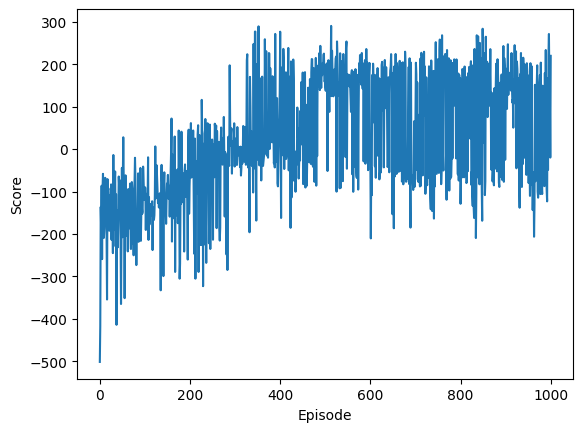

In [ ]:
if __name__ == "__main__":
    env = gym.make('LunarLander-v3',render_mode='rgb_array')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    scores = train(agent, env)
    plt.plot([i for i in range(len(scores))], scores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.show(block=True)



In [7]:
def play_DQN_episode(env, agent,save_path='DQN.gif'):
    score = 0
    state, _ = env.reset(seed=42)
    frames = []
    
    while True:
        frame = env.render()
        frames.append(frame)
        
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward

        if terminated or truncated:
            break
    imageio.mimsave(save_path, frames, duration=0.1,fps=60)
    
    env.close()
    return score

if __name__ == "__main__":
    env = gym.make('LunarLander-v3', render_mode='rgb_array')
    score = play_DQN_episode(env, agent)
    print("Score obtained:", score)


Score obtained: -260.82492059247664


Episode 0	Average Score: -66.50
Episode 100	Average Score: -166.60
Episode 200	Average Score: -103.74
Episode 300	Average Score: -49.974
Episode 400	Average Score: 10.359
Episode 500	Average Score: 80.78
Episode 600	Average Score: 154.07
Episode 700	Average Score: 172.57
Episode 800	Average Score: 135.05
Episode 900	Average Score: 117.39
Episode 1000	Average Score: 154.00
Score obtained: 133.36977034937735


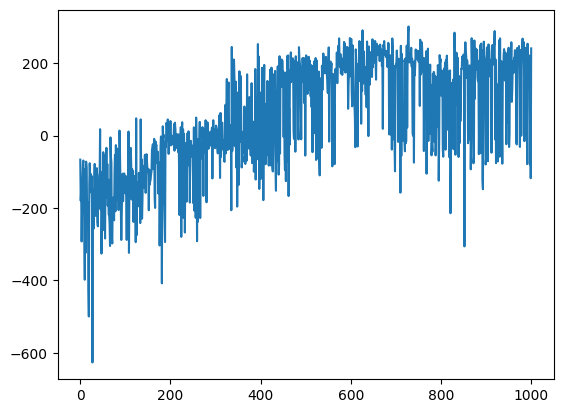

In [10]:
class DDQNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-4, gamma=0.99, buffer=10000, batch=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch = batch
        self.action_size = action_size
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer)
        self.loss_fn = nn.MSELoss()

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                action_values = self.q_network(state)
            return np.argmax(action_values.cpu().numpy())
        else:
            return random.randrange(self.action_size)  
        
    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_fn(q_values, expected_q_values.detach())
        
        self.optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

env = gym.make('LunarLander-v3',render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DDQNAgent(state_size, action_size)
scores = train(agent, env)
score = play_DQN_episode(env, agent,save_path='DDQN.gif')
print("Score obtained:", score)
plt.plot([i for i in range(len(scores))], scores)
plt.show()

In [ ]:
class 

ffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        self.priorities.append(max(self.priorities, default=1))

    def sample(self, batch_size):
        probs = np.array(self.priorities) ** 0.6
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (torch.FloatTensor(states),
                torch.LongTensor(actions),
                torch.FloatTensor(rewards),
                torch.FloatTensor(next_states),
                torch.FloatTensor(dones))

    def update_priorities(self, indices, td_errors):
        for i, td_error in zip(indices, td_errors):
            self.priorities[i] = abs(td_error) + 1e-6

    def __len__(self):
        return len(self.buffer)

class DuelingDQN(torch.nn.Module):
    def __init__(self, state_size=8, action_size=4, hidden_size=64):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.advantage = nn.Linear(hidden_size, action_size)
        self.value = nn.Linear(hidden_size, 1)
    def forward(self, state):
        features = self.feature(state)
        advantage = self.advantage(features)
        value = self.value(features)
        return value + (advantage - advantage.max(dim=1, keepdim=True)[0])

class DuelingDQNAgent:

    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-4, gamma=0.99, buffer=10000, batch=64):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch = batch
        self.action_size = action_size

        # Use the dueling DQN networks instead
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch:
            experiences = self.memory.sample(self.batch)
            self.update_model(*experiences)

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self, states, actions, rewards, next_states, dones):
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.SmoothL1Loss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1)
        self.optimizer.step()

        td_errors = (expected_q_values - q_values).detach().cpu().numpy()
        self.memory.update_priorities(range(len(self.memory)), td_errors)
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())




Episode 0	Average Score: -248.36
Episode 100	Average Score: -125.30
Episode 200	Average Score: -25.893
Episode 300	Average Score: 9.9725
Episode 400	Average Score: 15.65
Episode 500	Average Score: 91.04
Episode 600	Average Score: 107.33
Episode 700	Average Score: 112.84
Episode 800	Average Score: 154.91
Episode 900	Average Score: 197.98
Episode 1000	Average Score: 199.00
Score obtained: 109.86581999119802


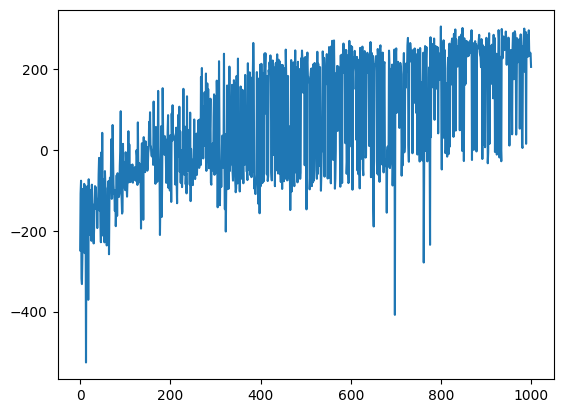

In [ ]:

# Make an environment
env = gym.make('LunarLander-v3',render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DuelingDQNAgent(state_size, action_size)
scores = train(agent, env)

score = play_DQN_episode(env, agent,save_path='DuelingDQN.gif')
print("Score obtained:", score)
plt.plot([i for i in range(len(scores))], scores)
plt.show()


Episode 0	Average Score: -38.80
Episode 100	Average Score: -121.86
Episode 200	Average Score: -27.322
Episode 300	Average Score: -33.15
Episode 400	Average Score: -5.175
Episode 500	Average Score: 164.05
Episode 600	Average Score: 163.72
Episode 700	Average Score: 174.93
Episode 800	Average Score: 172.59
Episode 900	Average Score: 185.84
Episode 1000	Average Score: 199.89
Score obtained: 83.25946477119224


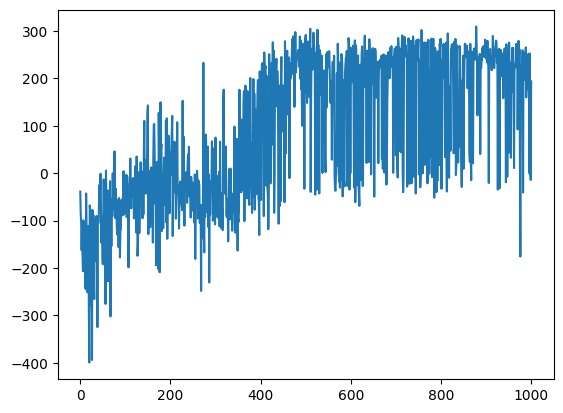

In [26]:

class D3QNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-4, gamma=0.99, buffer=10000, batch=64):
        super(D3QNAgent, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch = batch
        self.action_size = action_size
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch:
            experiences = self.memory.sample(self.batch)
            self.update_model(*experiences)

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
        
    def update_model(self, states, actions, rewards, next_states, dones):
        # Convert NumPy arrays to PyTorch tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = torch.nn.SmoothL1Loss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1)
        self.optimizer.step()

        td_errors = (expected_q_values - q_values).detach().cpu().numpy()
        indices = range(len(td_errors))  # Ensure indices correspond to TD errors
        self.memory.update_priorities(indices, td_errors)

env = gym.make('LunarLander-v3',render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = D3QNAgent(state_size, action_size)
scores = train(agent, env)

score = play_DQN_episode(env, agent,save_path='D3QN.gif')
print("Score obtained:", score)
plt.plot([i for i in range(len(scores))], scores)
plt.show(block=True)